<a href="https://colab.research.google.com/github/palit-ishan/IE_7374_Project/blob/master/ML_Project_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving bank-additional-full.csv to bank-additional-full.csv
Saving bank-additional.csv to bank-additional.csv
Saving bank-full.csv to bank-full.csv
Saving bank.csv to bank.csv


In [275]:
import pandas as pd
df_bank = pd.read_csv('bank.csv',sep = ';')
df_bank_full = pd.read_csv('bank-full.csv',sep = ';')
df_bank_additional = pd.read_csv('bank-additional.csv',sep = ';')
df_bank_additional_full = pd.read_csv('bank-additional-full.csv',sep = ';')

In [276]:
df_bank.shape,df_bank_full.shape,df_bank_additional.shape,df_bank_additional_full.shape

((4521, 17), (45211, 17), (4119, 21), (41188, 21))

Input variables:
1. age (numeric)
2. job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3. marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4. education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5. default: has credit in default? (categorical: 'no','yes','unknown')
6. housing: has housing loan? (categorical: 'no','yes','unknown')
7. loan: has personal loan? (categorical: 'no','yes','unknown')
8. contact: contact communication type (categorical: 'cellular','telephone')
9. month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10. day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11. duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
12. campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13. pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14. previous: number of contacts performed before this campaign and for this client (numeric)
15. poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')

Output variable (desired target):
21. y. has the client subscribed a term deposit? (binary: 'yes','no')

According to the dataset documentation, we need to remove the 'duration' column because in real-case the duration is only known after the label column is known. This problem can be considered to be 'data leakage' where predictors include data that will not be available at the time you make predictions.


In [277]:
# Checking null values in dataset
df_bank_full.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

No Null Values are there in the dataset


In [278]:
# Drop 'duration' column
df_bank_full = df_bank_full.drop('duration', axis=1)

In [279]:
# Splitting the full data into test and train data to avoid inherent biases in models
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_bank_full.iloc[:,0:-1],df_bank_full.iloc[:,-1] , test_size=0.2, random_state=42)

In [280]:
# A merged dataframe of the train set - input and output
df_bank_train = pd.merge(X_train, y_train, left_index=True, right_index=True)

We will scale our numerical data to avoid outlier presence that can significantly affect our model. Using `StandardScaler()` function from sklearn we can scale each our columns that contains numerical data. The scaling will be done using the formula below:

<div align="center">$Z = \frac{X - U}{S}$</div>

*Where:*

*$Z:$ scaled value*

*$X:$ original value*

*$U:$ mean of the data*

*$S:$ standard deviation of the data*



In [281]:
from sklearn.preprocessing import StandardScaler

# Copying original dataframe
df_bank_ready_train = df_bank_train.copy()

scaler = StandardScaler()
num_cols = ['age', 'balance', 'day', 'campaign', 'pdays', 'previous']
df_bank_ready_train[num_cols] = scaler.fit_transform(df_bank_ready_train[num_cols])

df_bank_ready_train.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,pdays,previous,poutcome,y
3344,0.006515,blue-collar,married,primary,no,-0.169381,yes,no,unknown,-0.098218,may,-0.565886,-0.411364,-0.244772,unknown,no
17965,0.759937,technician,married,primary,no,0.017848,yes,no,cellular,1.703422,jul,-0.245389,-0.411364,-0.244772,unknown,no
18299,0.100693,admin.,married,secondary,no,0.820681,no,no,cellular,1.823532,jul,0.395606,-0.411364,-0.244772,unknown,no
10221,-0.370196,management,single,tertiary,no,-0.489588,yes,no,unknown,-0.578656,jun,2.639088,-0.411364,-0.244772,unknown,no
32192,1.419181,blue-collar,married,primary,no,0.706889,no,no,cellular,-0.098218,apr,-0.245389,-0.411364,-0.244772,unknown,yes


In [282]:
# Renaming output column to 'deposit'
df_bank_ready_train = df_bank_ready_train.rename(columns = {'y':'deposit'})

In [283]:
df_bank_ready_train

,age,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,pdays,previous,poutcome,deposit
3344,0.006515,blue-collar,married,primary,no,-0.169381,yes,no,unknown,-0.098218,may,-0.565886,-0.411364,-0.244772,unknown,no
17965,0.759937,technician,married,primary,no,0.017848,yes,no,cellular,1.703422,jul,-0.245389,-0.411364,-0.244772,unknown,no
18299,0.100693,admin.,married,secondary,no,0.820681,no,no,cellular,1.823532,jul,0.395606,-0.411364,-0.244772,unknown,no
10221,-0.370196,management,single,tertiary,no,-0.489588,yes,no,unknown,-0.578656,jun,2.639088,-0.411364,-0.244772,unknown,no
32192,1.419181,blue-collar,married,primary,no,0.706889,no,no,cellular,-0.098218,apr,-0.245389,-0.411364,-0.244772,unknown,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11284,0.289048,housemaid,single,primary,no,-0.099915,no,no,unknown,0.262110,jun,-0.565886,-0.411364,-0.244772,unknown,yes
44732,-1.688684,student,single,tertiary,no,-0.282181,no,no,cellular,-0.938984,sep,-0.565886,0.517649,0.177056,failure,no
38158,-0.652729,technician,divorced,tertiary,no,-0.014570,yes,no,cellular,-0.098218,may,-0.565886,-0.411364,-0.244772,unknown,no
860,-0.746907,retired,married,secondary,no,-0.395643,no,no,unknown,-1.059093,may,-0.565886,-0.411364,-0.244772,unknown,no


In [284]:
df_bank_ready_train.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'campaign', 'pdays', 'previous',
       'poutcome', 'deposit'],
      dtype='object')

In [285]:
df_bank_ready_train

,age,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,pdays,previous,poutcome,deposit
3344,0.006515,blue-collar,married,primary,no,-0.169381,yes,no,unknown,-0.098218,may,-0.565886,-0.411364,-0.244772,unknown,no
17965,0.759937,technician,married,primary,no,0.017848,yes,no,cellular,1.703422,jul,-0.245389,-0.411364,-0.244772,unknown,no
18299,0.100693,admin.,married,secondary,no,0.820681,no,no,cellular,1.823532,jul,0.395606,-0.411364,-0.244772,unknown,no
10221,-0.370196,management,single,tertiary,no,-0.489588,yes,no,unknown,-0.578656,jun,2.639088,-0.411364,-0.244772,unknown,no
32192,1.419181,blue-collar,married,primary,no,0.706889,no,no,cellular,-0.098218,apr,-0.245389,-0.411364,-0.244772,unknown,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11284,0.289048,housemaid,single,primary,no,-0.099915,no,no,unknown,0.262110,jun,-0.565886,-0.411364,-0.244772,unknown,yes
44732,-1.688684,student,single,tertiary,no,-0.282181,no,no,cellular,-0.938984,sep,-0.565886,0.517649,0.177056,failure,no
38158,-0.652729,technician,divorced,tertiary,no,-0.014570,yes,no,cellular,-0.098218,may,-0.565886,-0.411364,-0.244772,unknown,no
860,-0.746907,retired,married,secondary,no,-0.395643,no,no,unknown,-1.059093,may,-0.565886,-0.411364,-0.244772,unknown,no


In [286]:
# There is class imbalance in the dataset - the number of no's are almost 8x the number of yes
y_train.value_counts()

no     31970
yes     4198
Name: y, dtype: int64

Text(0, 0.5, 'Class')

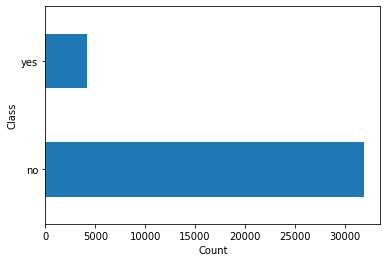

In [287]:
# Plotting Bar Charts for Yes/No counts 
import matplotlib.pyplot as plt
y_train.value_counts().plot(kind='barh')
plt.xlabel('Count')
plt.ylabel('Class')

In [288]:
#Analysing Job categories
X_train['job'].value_counts()

blue-collar      7806
management       7500
technician       6096
admin.           4137
services         3350
retired          1815
self-employed    1286
entrepreneur     1178
unemployed       1023
housemaid        1002
student           742
unknown           233
Name: job, dtype: int64

Text(0, 0.5, 'Job')

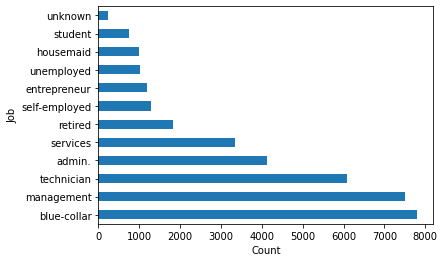

In [289]:
#Analysing Job categories
X_train['job'].value_counts().plot(kind='barh')
plt.xlabel('Count')
plt.ylabel('Job')

Text(0, 0.5, 'Marital')

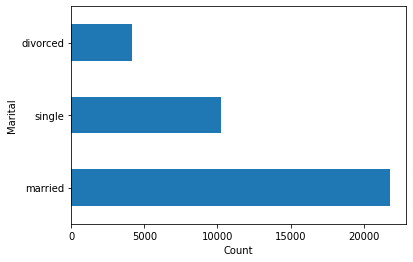

In [290]:
#Analysing Marital categories
X_train['marital'].value_counts().plot(kind='barh')
plt.xlabel('Count')
plt.ylabel('Marital')

Text(0, 0.5, 'Education')

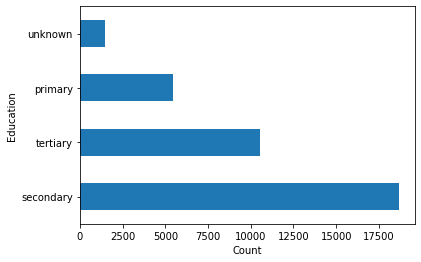

In [291]:
#Analysing education categories
X_train['education'].value_counts().plot(kind='barh')
plt.xlabel('Count')
plt.ylabel('Education')

Text(0, 0.5, 'Outcome of the previous marketing campaign')

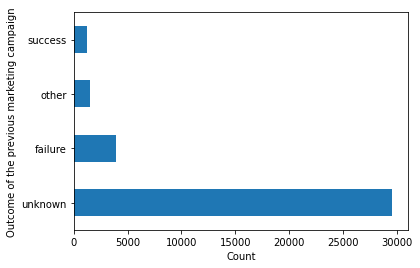

In [292]:
#Analysing Outcome of the previous marketing campaign  categories
X_train['poutcome'].value_counts().plot(kind='barh')
plt.xlabel('Count')
plt.ylabel('Outcome of the previous marketing campaign')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5cc1ea8c10>,
      dtype=object)

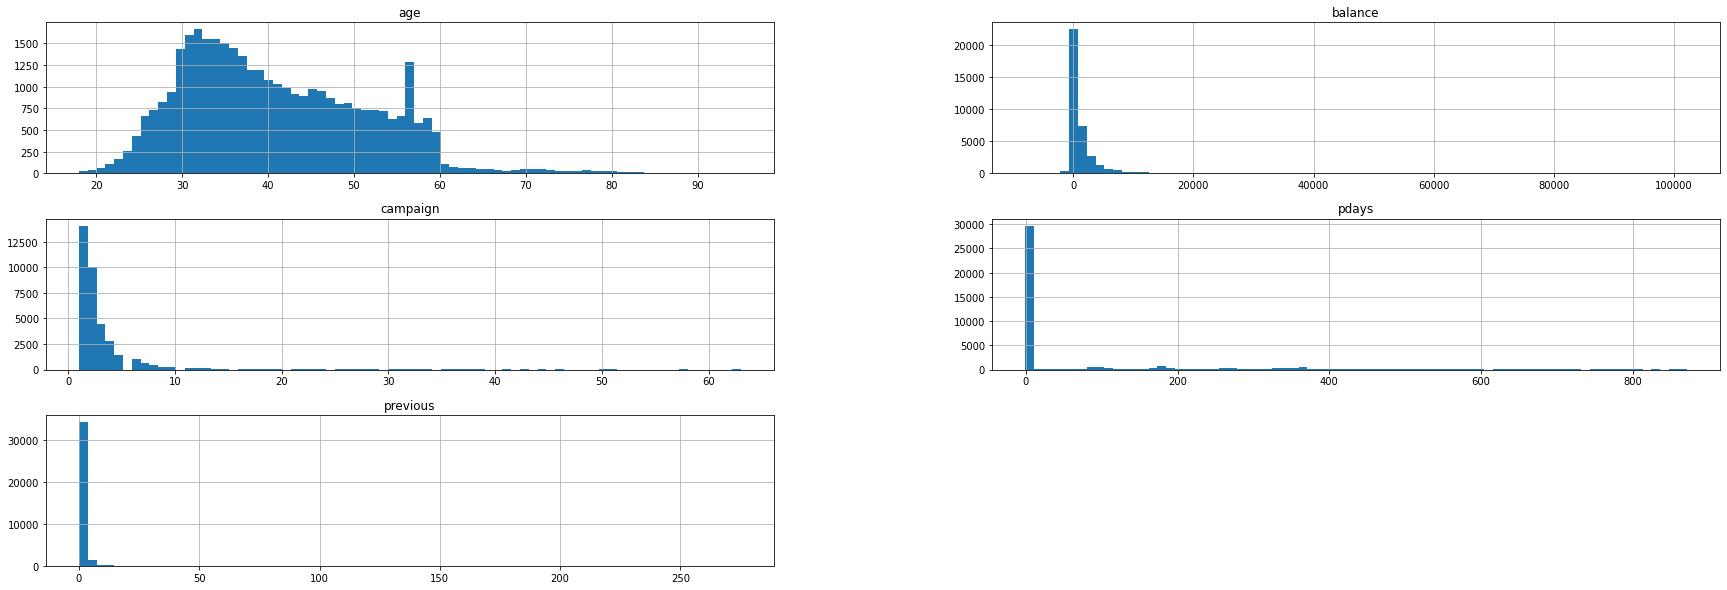

In [293]:
# Univariate Analysis
X_train.hist(column = ['age','balance','campaign','pdays','previous'],figsize = (30,10),bins = 75)

## Encode Categorical Value

Same as the numerical data, we also need to pre-process our categorical data from words to number to make it easier for the computer to understands. To do this we will use `OneHotEncoder()` provided by sklearn. Basically it will transform a categorical column from this:

| marital | housing |
|----------|---------|
| single   | yes     |
| divorced | no      |
| married  | no      |

...into something like this...

| marital_single | marital_divorced | marital_married | housing_yes | housing_no |
|----------------|------------------|-----------------|-------------|------------|
| 1              | 0                | 0               | 1           | 0          |
| 0              | 1                | 0               | 0           | 1          |
| 0              | 0                | 1               | 0           | 1          |

In this code cell we will also encode our label column by replacing 'yes' and 'no' with 1 and 0 respectively. We can do this by applying simple lambda/in-line function on the column.


In [294]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse=False)
cat_cols = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']

# Encode Categorical Data
df_encoded = pd.DataFrame(encoder.fit_transform(df_bank_ready_train[cat_cols]))
df_encoded.columns = encoder.get_feature_names(cat_cols)

# Replace Categotical Data with Encoded Data
df_bank_ready_train = df_bank_ready_train.drop(cat_cols ,axis=1)
df_bank_ready_train = df_bank_ready_train.reset_index(drop = True)
df_bank_ready_train = pd.concat([df_encoded, df_bank_ready_train], axis=1)


# Encode target value
df_bank_ready_train['deposit'] = df_bank_ready_train['deposit'].apply(lambda x: 1 if x == 'yes' else 0)

print('Shape of dataframe:', df_bank_ready_train.shape)
df_bank_ready_train.head()

Shape of dataframe: (36168, 51)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,...,poutcome_other,poutcome_success,poutcome_unknown,age,balance,day,campaign,pdays,previous,deposit
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.006515,-0.169381,-0.098218,-0.565886,-0.411364,-0.244772,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.759937,0.017848,1.703422,-0.245389,-0.411364,-0.244772,0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.100693,0.820681,1.823532,0.395606,-0.411364,-0.244772,0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,-0.370196,-0.489588,-0.578656,2.639088,-0.411364,-0.244772,0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.419181,0.706889,-0.098218,-0.245389,-0.411364,-0.244772,1
